This code takes the reprojected carbon stock layers and calculates zonal statistics across the y2y region based on protected area status.

In [1]:
# import packages
import geopandas as gpd
import numpy as np
import rioxarray
import xarray

import pandas as pd

from geocube.api.core import make_geocube

In [2]:
# load wdpa and wdoecm layers clipped to y2y and reproject to match rasters
wdpa = gpd.read_file('./land_cover/protected_areas_WDPA.shp').to_crs('+proj=laea +lat_0=55 +lon_0=-125 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
wdoecm = gpd.read_file('./land_cover/protected_areas_WDOECM.shp').to_crs('+proj=laea +lat_0=55 +lon_0=-125 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')


In [3]:
# explore wdpa layer
wdpa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1478 entries, 0 to 1477
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   WDPAID      1478 non-null   float64 
 1   WDPA_PID    1478 non-null   object  
 2   PA_DEF      1478 non-null   object  
 3   NAME        1478 non-null   object  
 4   ORIG_NAME   1478 non-null   object  
 5   DESIG       1478 non-null   object  
 6   DESIG_ENG   1478 non-null   object  
 7   DESIG_TYPE  1478 non-null   object  
 8   IUCN_CAT    1478 non-null   object  
 9   INT_CRIT    1478 non-null   object  
 10  MARINE      1478 non-null   object  
 11  REP_M_AREA  1478 non-null   float64 
 12  GIS_M_AREA  1478 non-null   float64 
 13  REP_AREA    1478 non-null   float64 
 14  GIS_AREA    1478 non-null   float64 
 15  NO_TAKE     1478 non-null   object  
 16  NO_TK_AREA  1478 non-null   float64 
 17  STATUS      1478 non-null   object  
 18  STATUS_YR   1478 non-null   int32   
 19

In [4]:
# unique gov_types
wdpa['GOV_TYPE'].unique()

array(['Sub-national ministry or agency', 'Collaborative governance',
       'Indigenous peoples', 'Federal or national ministry or agency',
       'Non-profit organisations', 'Joint governance',
       'Individual landowners', 'Not Reported'], dtype=object)

In [10]:
# total gis area grouped by gov type
wdpa.groupby('GOV_TYPE')['GIS_AREA'].sum().sort_values(ascending=False)

GOV_TYPE
Federal or national ministry or agency    150067.890944
Sub-national ministry or agency            89157.227696
Collaborative governance                   56219.593952
Not Reported                               55806.429403
Non-profit organisations                    3334.359287
Indigenous peoples                           513.253207
Joint governance                              78.814716
Individual landowners                          1.006097
Name: GIS_AREA, dtype: float64

In [12]:
# total area based on polygon projection grouped by gov type
wdpa['PROJ_AREA'] = wdpa.geometry.area
wdpa.groupby('GOV_TYPE')['PROJ_AREA'].sum().sort_values(ascending=False) / 1e+6 # km^2

GOV_TYPE
Federal or national ministry or agency    143082.106121
Sub-national ministry or agency            79685.376392
Not Reported                               55807.031479
Collaborative governance                   49106.134050
Non-profit organisations                    3239.680788
Indigenous peoples                           513.253154
Joint governance                              78.815676
Individual landowners                          1.006097
Name: PROJ_AREA, dtype: float64

In [15]:
# total area grouped by owner type
wdpa.groupby(['OWN_TYPE', 'GOV_TYPE'])['PROJ_AREA'].sum().sort_values(ascending=False) / 1e+6 # km^2


OWN_TYPE                  GOV_TYPE                              
State                     Federal or national ministry or agency    140512.943226
                          Sub-national ministry or agency            79418.123021
Not Reported              Not Reported                               55807.031479
Multiple ownership        Collaborative governance                   20451.760944
State                     Collaborative governance                   15426.044174
Joint ownership           Collaborative governance                   13228.328932
Individual landowners     Federal or national ministry or agency      2559.177594
                          Non-profit organisations                    1753.723528
Non-profit organisations  Non-profit organisations                    1485.957260
Not Reported              Indigenous peoples                           513.253154
                          Sub-national ministry or agency              209.170152
Joint ownership           Joint g

In [3]:
# filter by columns needed
eco = eco.filter(['OBJECTID', 'ECO_NAME', 'BIOME_NUM', 'BIOME_NAME', 'geometry'])
eco

,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,geometry
0,13.0,Alberta-British Columbia foothills forests,5.0,Temperate Conifer Forests,"MULTIPOLYGON (((231107.227 305009.454, 226734...."
1,74.0,Blue Mountains forests,5.0,Temperate Conifer Forests,"POLYGON ((614252.395 -1139094.041, 612099.656 ..."
2,83.0,British Columbia coastal conifer forests,5.0,Temperate Conifer Forests,"POLYGON ((-166421.245 37682.88, -177859.583 32..."
3,84.0,Brooks-British Range tundra,11.0,Tundra,"MULTIPOLYGON (((-514179.871 1392834.151, -5147..."
4,95.0,Canadian Aspen forests and parklands,8.0,"Temperate Grasslands, Savannas & Shrublands","MULTIPOLYGON (((725180.479 -339910.34, 723716...."
5,133.0,Central British Columbia Mountain forests,5.0,Temperate Conifer Forests,"POLYGON ((192654.361 -120678.524, 194329.256 -..."
6,272.0,Fraser Plateau and Basin conifer forests,5.0,Temperate Conifer Forests,"POLYGON ((298504.267 -341027.666, 298711.41 -3..."
7,337.0,Interior Alaska-Yukon lowland taiga,6.0,Boreal Forests/Taiga,"MULTIPOLYGON (((-627905.705 1421020.585, -6225..."
8,339.0,Interior Yukon-Alaska alpine tundra,11.0,Tundra,"MULTIPOLYGON (((-713662.418 1111909.509, -7138..."
9,438.0,Mid-Canada Boreal Plains forests,6.0,Boreal Forests/Taiga,"MULTIPOLYGON (((253378.224 142341.081, 266856...."


In [4]:
# rename id columns
eco = eco.rename(columns={'OBJECTID': 'ECO_ID', 'BIOME_NUM': 'BIOME_ID'})
eco

,ECO_ID,ECO_NAME,BIOME_ID,BIOME_NAME,geometry
0,13.0,Alberta-British Columbia foothills forests,5.0,Temperate Conifer Forests,"MULTIPOLYGON (((231107.227 305009.454, 226734...."
1,74.0,Blue Mountains forests,5.0,Temperate Conifer Forests,"POLYGON ((614252.395 -1139094.041, 612099.656 ..."
2,83.0,British Columbia coastal conifer forests,5.0,Temperate Conifer Forests,"POLYGON ((-166421.245 37682.88, -177859.583 32..."
3,84.0,Brooks-British Range tundra,11.0,Tundra,"MULTIPOLYGON (((-514179.871 1392834.151, -5147..."
4,95.0,Canadian Aspen forests and parklands,8.0,"Temperate Grasslands, Savannas & Shrublands","MULTIPOLYGON (((725180.479 -339910.34, 723716...."
5,133.0,Central British Columbia Mountain forests,5.0,Temperate Conifer Forests,"POLYGON ((192654.361 -120678.524, 194329.256 -..."
6,272.0,Fraser Plateau and Basin conifer forests,5.0,Temperate Conifer Forests,"POLYGON ((298504.267 -341027.666, 298711.41 -3..."
7,337.0,Interior Alaska-Yukon lowland taiga,6.0,Boreal Forests/Taiga,"MULTIPOLYGON (((-627905.705 1421020.585, -6225..."
8,339.0,Interior Yukon-Alaska alpine tundra,11.0,Tundra,"MULTIPOLYGON (((-713662.418 1111909.509, -7138..."
9,438.0,Mid-Canada Boreal Plains forests,6.0,Boreal Forests/Taiga,"MULTIPOLYGON (((253378.224 142341.081, 266856...."


In [5]:
# load land carbon in tonnes
carbon_t = rioxarray.open_rasterio(
    './carbon_stock_data/output_layers/carbon_sothe_spawn_t_laea.tif', masked=True
).rio.clip(
    eco.geometry.values, eco.crs, from_disk=True)
carbon_t.name = "carbon_t"

# load land carbon in t/ha
carbon_t_ha = rioxarray.open_rasterio(
    './carbon_stock_data/output_layers/carbon_sothe_spawn_t_ha_laea.tif', masked=True
).rio.clip(
    eco.geometry.values, eco.crs, from_disk=True)
carbon_t_ha.name = "carbon_t_ha"

In [6]:
# load soc in tonnes
soc_t = rioxarray.open_rasterio(
    './carbon_stock_data/output_layers/soc_0_1m_t_laea.tif', masked=True
).rio.clip(
    eco.geometry.values, eco.crs, from_disk=True)
soc_t.name = "soc_t"

# load soc in t/ha
soc_t_ha = rioxarray.open_rasterio(
    './carbon_stock_data/output_layers/soc_0_1m_t_ha_laea.tif', masked=True
).rio.clip(
    eco.geometry.values, eco.crs, from_disk=True)
soc_t_ha.name = "soc_t_ha"

In [7]:
# create output grid
out_grid = make_geocube(
    vector_data=eco,
    measurements=['ECO_ID', 'BIOME_ID'],
    like=carbon_t
)
out_grid

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 11122, x: 8514)
Coordinates:
  * y            (y) float64 89kB 1.429e+06 1.428e+06 ... -1.351e+06 -1.352e+06
  * x            (x) float64 68kB -7.585e+05 -7.582e+05 ... 1.37e+06 1.37e+06
    spatial_ref  int64 8B 0
Data variables:
    ECO_ID       (y, x) float64 758MB nan nan nan nan nan ... nan nan nan nan
    BIOME_ID     (y, x) float64 758MB nan nan nan nan nan ... nan nan nan nan

In [8]:
# merge the datacube with the carbon variables together
out_grid['carbon_t'] = (carbon_t.dims, carbon_t.values, carbon_t.attrs, carbon_t.encoding)
out_grid['carbon_t_ha'] = (carbon_t_ha.dims, carbon_t_ha.values, carbon_t_ha.attrs, carbon_t_ha.encoding)
out_grid['soc_t'] = (soc_t.dims, soc_t.values, soc_t.attrs, soc_t.encoding)
out_grid['soc_t_ha'] = (soc_t_ha.dims, soc_t_ha.values, soc_t_ha.attrs, soc_t_ha.encoding)
out_grid

<xarray.Dataset> Size: 5GB
Dimensions:      (y: 11122, x: 8514, band: 1)
Coordinates:
  * y            (y) float64 89kB 1.429e+06 1.428e+06 ... -1.351e+06 -1.352e+06
  * x            (x) float64 68kB -7.585e+05 -7.582e+05 ... 1.37e+06 1.37e+06
    spatial_ref  int64 8B 0
Dimensions without coordinates: band
Data variables:
    ECO_ID       (y, x) float64 758MB nan nan nan nan nan ... nan nan nan nan
    BIOME_ID     (y, x) float64 758MB nan nan nan nan nan ... nan nan nan nan
    carbon_t     (band, y, x) float64 758MB nan nan nan nan ... nan nan nan nan
    carbon_t_ha  (band, y, x) float64 758MB nan nan nan nan ... nan nan nan nan
    soc_t        (band, y, x) float64 758MB nan nan nan nan ... nan nan nan nan
    soc_t_ha     (band, y, x) float64 758MB nan nan nan nan ... nan nan nan nan

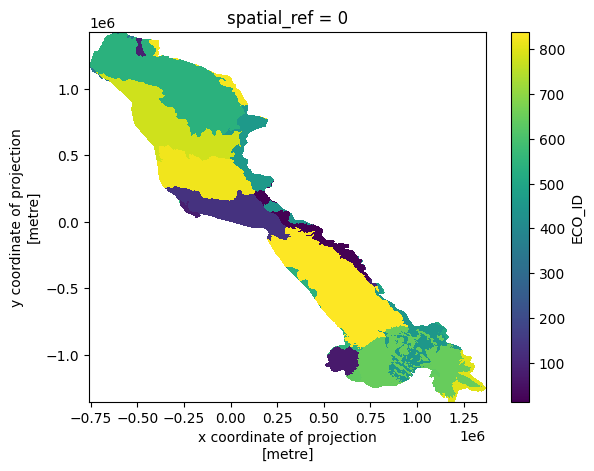

In [9]:
# plot the ecoregions
out_grid.ECO_ID.plot.imshow()

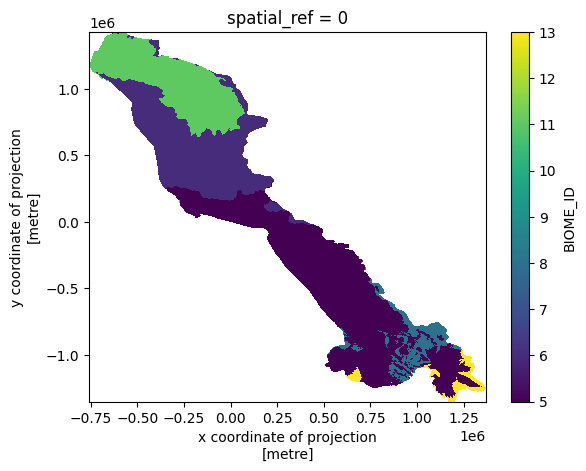

In [10]:
# plot the biomes
out_grid.BIOME_ID.plot.imshow()

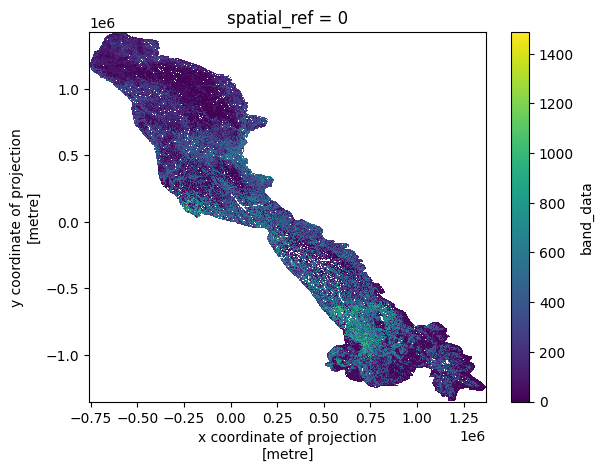

In [11]:
# plot the carbon
out_grid.carbon_t.plot()

In [12]:
# get carbon stats by ecoregion and biome
# group data by ecoregion for total carbon
grouped_eco_total = out_grid.drop_vars(['BIOME_ID', 'spatial_ref', 'carbon_t_ha', 'soc_t_ha']).groupby('ECO_ID')

# group data by biome for total carbon
grouped_biome_total = out_grid.drop_vars(['ECO_ID', 'spatial_ref', 'carbon_t_ha', 'soc_t_ha']).groupby('BIOME_ID')

In [13]:
# calculate total carbon by ecoregion
total_c_eco = grouped_eco_total.sum().rename(
        {'carbon_t': 'total_carbon',
         'soc_t': 'total_soc'}
        )

# calculate total carbon by biome
total_c_biome = grouped_biome_total.sum().rename(
        {'carbon_t': 'total_carbon',
         'soc_t': 'total_soc'}
        )

/Users/bermane/Team Braintree Dropbox/Ethan Berman/Python Projects/y2y-carbon/.venv/lib/python3.12/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension ECO_ID because variable ECO_ID is not a coordinate. To create an index for ECO_ID, please first call `.set_coords('ECO_ID')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/Users/bermane/Team Braintree Dropbox/Ethan Berman/Python Projects/y2y-carbon/.venv/lib/python3.12/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension BIOME_ID because variable BIOME_ID is not a coordinate. To create an index for BIOME_ID, please first call `.set_coords('BIOME_ID')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


In [14]:
# group data by ecoregion for average carbon density
grouped_eco_avg = out_grid.drop_vars(['BIOME_ID', 'spatial_ref', 'carbon_t', 'soc_t']).groupby('ECO_ID')

# group data by biome for average carbon density
grouped_biome_avg = out_grid.drop_vars(['ECO_ID', 'spatial_ref', 'carbon_t', 'soc_t']).groupby('BIOME_ID')

In [15]:
# calculate average carbon density by ecoregion
avg_c_eco = grouped_eco_avg.mean().rename(
        {'carbon_t_ha': 'avg_carbon_density',
         'soc_t_ha': 'avg_soc_density'}
        )

# calculate average carbon density by biome
avg_c_biome = grouped_biome_avg.mean().rename(
        {'carbon_t_ha': 'avg_carbon_density',
         'soc_t_ha': 'avg_soc_density'}
        )

/Users/bermane/Team Braintree Dropbox/Ethan Berman/Python Projects/y2y-carbon/.venv/lib/python3.12/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension ECO_ID because variable ECO_ID is not a coordinate. To create an index for ECO_ID, please first call `.set_coords('ECO_ID')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/Users/bermane/Team Braintree Dropbox/Ethan Berman/Python Projects/y2y-carbon/.venv/lib/python3.12/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension BIOME_ID because variable BIOME_ID is not a coordinate. To create an index for BIOME_ID, please first call `.set_coords('BIOME_ID')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


In [16]:
# merge zonal stats
stats_eco = xarray.merge([total_c_eco, avg_c_eco]).to_dataframe()
stats_biome = xarray.merge([total_c_biome, avg_c_biome]).to_dataframe()

In [17]:
# drop band index
stats_eco.reset_index(inplace=True)
stats_biome.reset_index(inplace=True)

# # set ECO_ID to ECO_NAME map
# eco_map = dict(zip(eco['ECO_ID'], eco['ECO_NAME']))

# # set BIOME_ID to BIOME_NAME map
# biome_map = dict(zip(eco['BIOME_ID'], eco['BIOME_NAME']))

# # replace ECO_ID with ECO_NAME
# stats_eco.rename(index=eco_map, inplace=True)

# # replace BIOME_ID with BIOME_NAME
# stats_biome.rename(index=biome_map, inplace=True)

# change tonnes carbon to Pg carbon
stats_eco['total_carbon'] /= 1e+09
stats_eco['total_soc'] /= 1e+09
stats_biome['total_carbon'] /= 1e+09
stats_biome['total_soc'] /= 1e+09
stats_eco

,ECO_ID,band,total_carbon,total_soc,avg_carbon_density,avg_soc_density
0,13.0,0,0.235617,0.628577,51.875723,138.438498
1,74.0,0,0.141362,0.325932,51.002047,117.833526
2,83.0,0,0.042514,0.090874,95.729952,205.112782
3,84.0,0,0.007826,0.135312,17.801833,307.750048
4,95.0,0,0.002829,0.032326,21.429108,244.942044
5,133.0,0,0.607495,1.697009,62.469650,174.624412
6,272.0,0,0.000046,0.000130,59.765574,170.211475
7,337.0,0,0.001093,0.058824,17.724394,961.860991
8,339.0,0,0.004798,0.026438,45.780841,253.180004
9,438.0,0,0.048127,0.107079,49.877737,111.053668


In [18]:
stats_biome

,BIOME_ID,band,total_carbon,total_soc,avg_carbon_density,avg_soc_density
0,5.0,0,3.455335,11.325572,58.816887,193.099275
1,6.0,0,1.494365,8.435799,40.600871,229.473025
2,8.0,0,0.106191,0.869438,14.147048,116.215565
3,11.0,0,0.473845,7.451530,16.939621,266.504353
4,13.0,0,0.020375,0.279285,7.046919,96.955720


In [19]:
# total carbon stored (+sanity check should be equal across tables)
print(stats_eco['total_carbon'].sum())
print(stats_biome['total_carbon'].sum())
print(stats_eco['total_soc'].sum())
print(stats_biome['total_soc'].sum())

5.550111329265042
5.550111329265044
28.36162394667293
28.36162394667293


In [20]:
# add ecoregion stats to vector data
ecoregions = eco.merge(stats_eco, on='ECO_ID')
ecoregions

,ECO_ID,ECO_NAME,BIOME_ID,BIOME_NAME,geometry,band,total_carbon,total_soc,avg_carbon_density,avg_soc_density
0,13.0,Alberta-British Columbia foothills forests,5.0,Temperate Conifer Forests,"MULTIPOLYGON (((231107.227 305009.454, 226734....",0,0.235617,0.628577,51.875723,138.438498
1,74.0,Blue Mountains forests,5.0,Temperate Conifer Forests,"POLYGON ((614252.395 -1139094.041, 612099.656 ...",0,0.141362,0.325932,51.002047,117.833526
2,83.0,British Columbia coastal conifer forests,5.0,Temperate Conifer Forests,"POLYGON ((-166421.245 37682.88, -177859.583 32...",0,0.042514,0.090874,95.729952,205.112782
3,84.0,Brooks-British Range tundra,11.0,Tundra,"MULTIPOLYGON (((-514179.871 1392834.151, -5147...",0,0.007826,0.135312,17.801833,307.750048
4,95.0,Canadian Aspen forests and parklands,8.0,"Temperate Grasslands, Savannas & Shrublands","MULTIPOLYGON (((725180.479 -339910.34, 723716....",0,0.002829,0.032326,21.429108,244.942044
5,133.0,Central British Columbia Mountain forests,5.0,Temperate Conifer Forests,"POLYGON ((192654.361 -120678.524, 194329.256 -...",0,0.607495,1.697009,62.469650,174.624412
6,272.0,Fraser Plateau and Basin conifer forests,5.0,Temperate Conifer Forests,"POLYGON ((298504.267 -341027.666, 298711.41 -3...",0,0.000046,0.000130,59.765574,170.211475
7,337.0,Interior Alaska-Yukon lowland taiga,6.0,Boreal Forests/Taiga,"MULTIPOLYGON (((-627905.705 1421020.585, -6225...",0,0.001093,0.058824,17.724394,961.860991
8,339.0,Interior Yukon-Alaska alpine tundra,11.0,Tundra,"MULTIPOLYGON (((-713662.418 1111909.509, -7138...",0,0.004798,0.026438,45.780841,253.180004
9,438.0,Mid-Canada Boreal Plains forests,6.0,Boreal Forests/Taiga,"MULTIPOLYGON (((253378.224 142341.081, 266856....",0,0.048127,0.107079,49.877737,111.053668


In [21]:
# clean up vector data
ecoregions.drop('band', axis=1, inplace=True)
ecoregions.rename(columns={'total_carbon': 'c_pg',
                           'total_soc': 'soc_pg',
                           'avg_carbon_density': 'c_t_ha',
                           'avg_soc_density': 'soc_t_ha'},
                           inplace=True)
ecoregions

,ECO_ID,ECO_NAME,BIOME_ID,BIOME_NAME,geometry,c_pg,soc_pg,c_t_ha,soc_t_ha
0,13.0,Alberta-British Columbia foothills forests,5.0,Temperate Conifer Forests,"MULTIPOLYGON (((231107.227 305009.454, 226734....",0.235617,0.628577,51.875723,138.438498
1,74.0,Blue Mountains forests,5.0,Temperate Conifer Forests,"POLYGON ((614252.395 -1139094.041, 612099.656 ...",0.141362,0.325932,51.002047,117.833526
2,83.0,British Columbia coastal conifer forests,5.0,Temperate Conifer Forests,"POLYGON ((-166421.245 37682.88, -177859.583 32...",0.042514,0.090874,95.729952,205.112782
3,84.0,Brooks-British Range tundra,11.0,Tundra,"MULTIPOLYGON (((-514179.871 1392834.151, -5147...",0.007826,0.135312,17.801833,307.750048
4,95.0,Canadian Aspen forests and parklands,8.0,"Temperate Grasslands, Savannas & Shrublands","MULTIPOLYGON (((725180.479 -339910.34, 723716....",0.002829,0.032326,21.429108,244.942044
5,133.0,Central British Columbia Mountain forests,5.0,Temperate Conifer Forests,"POLYGON ((192654.361 -120678.524, 194329.256 -...",0.607495,1.697009,62.469650,174.624412
6,272.0,Fraser Plateau and Basin conifer forests,5.0,Temperate Conifer Forests,"POLYGON ((298504.267 -341027.666, 298711.41 -3...",0.000046,0.000130,59.765574,170.211475
7,337.0,Interior Alaska-Yukon lowland taiga,6.0,Boreal Forests/Taiga,"MULTIPOLYGON (((-627905.705 1421020.585, -6225...",0.001093,0.058824,17.724394,961.860991
8,339.0,Interior Yukon-Alaska alpine tundra,11.0,Tundra,"MULTIPOLYGON (((-713662.418 1111909.509, -7138...",0.004798,0.026438,45.780841,253.180004
9,438.0,Mid-Canada Boreal Plains forests,6.0,Boreal Forests/Taiga,"MULTIPOLYGON (((253378.224 142341.081, 266856....",0.048127,0.107079,49.877737,111.053668


In [22]:
# create vector data for biomes
biomes = eco.dissolve(by=['BIOME_ID', 'BIOME_NAME'])

# reset index columns
biomes.reset_index(inplace=True)

# drop ECO_ID and ECO_NAME columns
biomes.drop(columns=['ECO_ID', 'ECO_NAME'], inplace=True)
biomes

,BIOME_ID,BIOME_NAME,geometry
0,5.0,Temperate Conifer Forests,"MULTIPOLYGON (((860037.383 -1112586.188, 86041..."
1,6.0,Boreal Forests/Taiga,"MULTIPOLYGON (((-384568.64 331052.75, -392936...."
2,8.0,"Temperate Grasslands, Savannas & Shrublands","MULTIPOLYGON (((531149.592 -972252.527, 531276..."
3,11.0,Tundra,"MULTIPOLYGON (((-274805.51 149096.379, -274330..."
4,13.0,Deserts & Xeric Shrublands,"MULTIPOLYGON (((1098249.445 -1270028.854, 1096..."


In [23]:
# add biome stats to vector data
biomes = biomes.merge(stats_biome, on='BIOME_ID')
biomes

,BIOME_ID,BIOME_NAME,geometry,band,total_carbon,total_soc,avg_carbon_density,avg_soc_density
0,5.0,Temperate Conifer Forests,"MULTIPOLYGON (((860037.383 -1112586.188, 86041...",0,3.455335,11.325572,58.816887,193.099275
1,6.0,Boreal Forests/Taiga,"MULTIPOLYGON (((-384568.64 331052.75, -392936....",0,1.494365,8.435799,40.600871,229.473025
2,8.0,"Temperate Grasslands, Savannas & Shrublands","MULTIPOLYGON (((531149.592 -972252.527, 531276...",0,0.106191,0.869438,14.147048,116.215565
3,11.0,Tundra,"MULTIPOLYGON (((-274805.51 149096.379, -274330...",0,0.473845,7.451530,16.939621,266.504353
4,13.0,Deserts & Xeric Shrublands,"MULTIPOLYGON (((1098249.445 -1270028.854, 1096...",0,0.020375,0.279285,7.046919,96.955720


In [24]:
# clean up vector data
biomes.drop('band', axis=1, inplace=True)
biomes.rename(columns={'total_carbon': 'c_pg',
                           'total_soc': 'soc_pg',
                           'avg_carbon_density': 'c_t_ha',
                           'avg_soc_density': 'soc_t_ha'},
                           inplace=True)
biomes

,BIOME_ID,BIOME_NAME,geometry,c_pg,soc_pg,c_t_ha,soc_t_ha
0,5.0,Temperate Conifer Forests,"MULTIPOLYGON (((860037.383 -1112586.188, 86041...",3.455335,11.325572,58.816887,193.099275
1,6.0,Boreal Forests/Taiga,"MULTIPOLYGON (((-384568.64 331052.75, -392936....",1.494365,8.435799,40.600871,229.473025
2,8.0,"Temperate Grasslands, Savannas & Shrublands","MULTIPOLYGON (((531149.592 -972252.527, 531276...",0.106191,0.869438,14.147048,116.215565
3,11.0,Tundra,"MULTIPOLYGON (((-274805.51 149096.379, -274330...",0.473845,7.451530,16.939621,266.504353
4,13.0,Deserts & Xeric Shrublands,"MULTIPOLYGON (((1098249.445 -1270028.854, 1096...",0.020375,0.279285,7.046919,96.955720


In [25]:
# write to file
ecoregions.to_file('./carbon_stock_data/output_layers/ecoregions_biomes/ecoregions_carbon_stock.shp')
biomes.to_file('./carbon_stock_data/output_layers/ecoregions_biomes/biomes_carbon_stock.shp')

In [37]:
# add area to biomes table in ha
# 1 m2 = 0.0001 ha
biomes['area_ha'] = biomes.area / 10000
biomes['area_pc'] = biomes['area_ha'] / biomes['area_ha'].sum()
biomes


,BIOME_ID,BIOME_NAME,geometry,c_pg,soc_pg,c_t_ha,soc_t_ha,area_ha,area_pc
0,5.0,Temperate Conifer Forests,"MULTIPOLYGON (((860037.383 -1112586.188, 86041...",3.455335,11.325572,58.816887,193.099275,6.042429e+07,0.441091
1,6.0,Boreal Forests/Taiga,"MULTIPOLYGON (((-384568.64 331052.75, -392936....",1.494365,8.435799,40.600871,229.473025,3.771248e+07,0.275297
2,8.0,"Temperate Grasslands, Savannas & Shrublands","MULTIPOLYGON (((531149.592 -972252.527, 531276...",0.106191,0.869438,14.147048,116.215565,7.557862e+06,0.055172
3,11.0,Tundra,"MULTIPOLYGON (((-274805.51 149096.379, -274330...",0.473845,7.451530,16.939621,266.504353,2.838068e+07,0.207176
4,13.0,Deserts & Xeric Shrublands,"MULTIPOLYGON (((1098249.445 -1270028.854, 1096...",0.020375,0.279285,7.046919,96.955720,2.912918e+06,0.021264


In [90]:
# drop geometry
biomes_df = biomes.drop('geometry', axis=1)

# add totals row
biomes_df = pd.concat([biomes_df, biomes_df.sum().to_frame().transpose()], ignore_index=True)
biomes_df


,BIOME_ID,BIOME_NAME,c_pg,soc_pg,c_t_ha,soc_t_ha,area_ha,area_pc
0,5.0,Temperate Conifer Forests,3.455335,11.325572,58.816887,193.099275,60424290.322885,0.441091
1,6.0,Boreal Forests/Taiga,1.494365,8.435799,40.600871,229.473025,37712475.554948,0.275297
2,8.0,"Temperate Grasslands, Savannas & Shrublands",0.106191,0.869438,14.147048,116.215565,7557862.323312,0.055172
3,11.0,Tundra,0.473845,7.45153,16.939621,266.504353,28380680.541698,0.207176
4,13.0,Deserts & Xeric Shrublands,0.020375,0.279285,7.046919,96.95572,2912918.176846,0.021264
5,43.0,Temperate Conifer ForestsBoreal Forests/TaigaT...,5.550111,28.361624,137.551346,902.247939,136988226.919689,1.0


In [105]:
# clean up Y2Y row names
biomes_df.loc[len(biomes_df) - 1, 'BIOME_ID'] = 0
biomes_df.loc[len(biomes_df) - 1, 'BIOME_NAME'] = 'Y2Y'

# change Y2Y rows to average for density
biomes_df.loc[len(biomes_df) - 1, 'c_t_ha'] = biomes_df.loc[:len(biomes_df) - 2, 'c_t_ha'].mean()
biomes_df.loc[len(biomes_df) - 1, 'soc_t_ha'] = biomes_df.loc[:len(biomes_df) - 2, 'soc_t_ha'].mean()

# get all columns except biome_name
cols = [col for col in biomes_df.columns if col != 'BIOME_NAME']

# convert to numeric
biomes_df[cols] = biomes_df[cols].apply(pd.to_numeric)

# round columns
decimals = pd.Series([1,1,1,1,1,2], index=['c_pg', 'soc_pg', 'c_t_ha', 'soc_t_ha', 'area_ha', 'area_pc'])
biomes_df = biomes_df.round(decimals)
biomes_df


,BIOME_ID,BIOME_NAME,c_pg,soc_pg,c_t_ha,soc_t_ha,area_ha,area_pc
0,5.0,Temperate Conifer Forests,3.5,11.3,58.8,193.1,60424290.3,0.44
1,6.0,Boreal Forests/Taiga,1.5,8.4,40.6,229.5,37712475.6,0.28
2,8.0,"Temperate Grasslands, Savannas & Shrublands",0.1,0.9,14.1,116.2,7557862.3,0.06
3,11.0,Tundra,0.5,7.5,16.9,266.5,28380680.5,0.21
4,13.0,Deserts & Xeric Shrublands,0.0,0.3,7.0,97.0,2912918.2,0.02
5,0.0,Y2Y,5.6,28.4,27.5,180.5,136988226.9,1.00


In [107]:
# export to csv
biomes_df.to_csv('./carbon_stock_data/output_layers/biomes_carbon_stocks.csv', index=False)